# fazekas v4
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
%load_ext autoreload

In [2]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets_v2.mri_dataset_inram import MRISegmentation3DDataset
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser
 
from trustworthai.journal_run.new_MIA_fazekas_and_QC.dataset_setup import *

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import scipy
import scipy.stats
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [3]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [4]:
class_labels = ['C0', 'C1', 'C2', 'C3']
n_classes = 4

In [5]:
cvd_data, adni_data, challenge_data, mss3_data = load_spreadsheets(include_MSS3=True)

challenge shapes before and after cleanup
(175, 1532)
(175, 1465)
cvd shapes before and after cleanup
(250, 1552)
(250, 1402)
adni shapes before and after cleanup
(299, 1544)
(299, 1374)
mss3 shapes before and after cleanup
(68, 46)
(68, 44)


In [6]:
adni_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/ADNI300/ADNI_300_feature_spreadsheets"
cvd_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/Ed_CVD/EdData_feature_spreadsheets"
challenge_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/WMHChallenge_InterRaterData/feature_spreadsheets"
mss3_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/MSS3_InterRaterData/feature_spreadsheets"

In [8]:
cvd_sdata = {}
cvd_sdata['ssn_ens'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
cvd_sdata['ssn_ens']['ID'] = cvd_sdata['ssn_ens']['pID']
cvd_sdata['punet'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
cvd_sdata['punet']['ID'] = cvd_sdata['punet']['pID']
cvd_sdata['deterministic'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))
cvd_sdata['deterministic']['ID'] = cvd_sdata['deterministic']['pID']

adni_sdata = {}
adni_sdata['ssn_ens'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
adni_sdata['punet'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
adni_sdata['deterministic'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))

challenge_sdata = {}
challenge_sdata['ssn_ens'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
challenge_sdata['punet'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
challenge_sdata['deterministic'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))

mss3_sdata = {}
mss3_sdata['ssn_ens'] = pd.read_csv(os.path.join(mss3_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
mss3_sdata['ssn_ens']['ID'] = mss3_sdata['ssn_ens']['pID']
mss3_sdata['punet'] = pd.read_csv(os.path.join(mss3_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
mss3_sdata['punet']['ID'] = mss3_sdata['punet']['pID']
mss3_sdata['deterministic'] = pd.read_csv(os.path.join(mss3_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))
mss3_sdata['deterministic']['ID'] = mss3_sdata['deterministic']['pID']


In [10]:
def combine_dss(features_df, clin_df):
    features_df = features_df.fillna(0)
    faz_df = clin_df[['ID', 'WMH_PV', 'WMH_Deep']]
    df = pd.merge(features_df, faz_df, on='ID', how='inner')
    df = df.dropna(subset=['WMH_PV', 'WMH_Deep'])
    return df

In [11]:
cvd_sdata['ssn_ens'] = combine_dss(cvd_sdata['ssn_ens'], cvd_data['ssn_ens'])
cvd_sdata['punet'] = combine_dss(cvd_sdata['punet'], cvd_data['punet'])
cvd_sdata['deterministic'] = combine_dss(cvd_sdata['deterministic'], cvd_data['deterministic'])

adni_sdata['ssn_ens'] = combine_dss(adni_sdata['ssn_ens'], adni_data['ssn_ens'])
adni_sdata['punet'] = combine_dss(adni_sdata['punet'], adni_data['punet'])
adni_sdata['deterministic'] = combine_dss(adni_sdata['deterministic'], adni_data['deterministic'])

challenge_sdata['ssn_ens'] = combine_dss(challenge_sdata['ssn_ens'], challenge_data['ssn_ens'])
challenge_sdata['punet'] = combine_dss(challenge_sdata['punet'], challenge_data['punet'])
challenge_sdata['deterministic'] = combine_dss(challenge_sdata['deterministic'], challenge_data['deterministic'])

mss3_sdata['ssn_ens'] = combine_dss(mss3_sdata['ssn_ens'], mss3_data['ssn_ens'])
mss3_sdata['punet'] = combine_dss(mss3_sdata['punet'], mss3_data['punet'])
mss3_sdata['deterministic'] = combine_dss(mss3_sdata['deterministic'], mss3_data['deterministic'])

In [12]:
def get_sample_keys(df):
    sample_keys = []
    for key in df.columns:
        if key.startswith("sample_"):
            key_type = "_".join(key.split("_")[2:])
            if key_type not in sample_keys:
                sample_keys.append(key_type)
                
    return sample_keys

In [13]:
def extract_sample_values(df, key):
    key_per_sample = df[[f'sample_{s}_{key}' for s in range(10)]]
    return key_per_sample

In [14]:
def uncertainty_dfs(df, sample_keys):
    df_new = df.copy()
    new_cols = {'ID':df['ID'].values}

    for key in sample_keys:
        key_samples = extract_sample_values(df, key).values.astype(np.float32)
        key_mean = df[f'mean_{key}'].values.reshape(-1, 1).astype(np.float32)
        vd_key_samples = 100 * (key_samples - key_mean) / (key_mean + 1e-5)
        
        # new_cols[f'p75_{key}'] = np.percentile(key_samples, 0.75, axis=1)
        # new_cols[f'p25_{key}'] = np.percentile(key_samples, 0.25, axis=1)
        new_cols[f'std_{key}'] = np.std(key_samples, axis=1)
        new_cols[f'iqr_{key}'] = scipy.stats.iqr(key_samples, axis=1)
        
        # new_cols[f'vd_p75_{key}'] = np.percentile(vd_key_samples, 0.75, axis=1)
        # new_cols[f'vd_p25_{key}'] = np.percentile(vd_key_samples, 0.25, axis=1)
        new_cols[f'vd_std_{key}'] = np.std(vd_key_samples, axis=1)
        new_cols[f'vd_iqr_{key}'] = scipy.stats.iqr(vd_key_samples, axis=1)
        # break/
    
    return pd.merge(df, pd.DataFrame(new_cols), on='ID', how='inner')

In [15]:
cvd_sdata['ssn_ens'] = uncertainty_dfs(cvd_sdata['ssn_ens'], get_sample_keys(cvd_sdata['ssn_ens']))
cvd_sdata['punet'] = uncertainty_dfs(cvd_sdata['punet'], get_sample_keys(cvd_sdata['punet']))

adni_sdata['ssn_ens'] = uncertainty_dfs(adni_sdata['ssn_ens'], get_sample_keys(adni_sdata['ssn_ens']))
adni_sdata['punet'] = uncertainty_dfs(adni_sdata['punet'], get_sample_keys(adni_sdata['punet']))

challenge_sdata['ssn_ens'] = uncertainty_dfs(challenge_sdata['ssn_ens'], get_sample_keys(challenge_sdata['ssn_ens']))
challenge_sdata['punet'] = uncertainty_dfs(challenge_sdata['punet'], get_sample_keys(challenge_sdata['punet']))

mss3_sdata['ssn_ens'] = uncertainty_dfs(mss3_sdata['ssn_ens'], get_sample_keys(mss3_sdata['ssn_ens']))
mss3_sdata['punet'] = uncertainty_dfs(mss3_sdata['punet'], get_sample_keys(mss3_sdata['punet']))

In [16]:
def select_sample(df, sample_num=None, extra_cols=[], uncert_cols=[], excludes=[]):
    if sample_num == None:
        col_start = "mean"
    else:
        col_start = f"sample_{sample_num}"
        
    cols = df.columns.values
    selected_cols = [c for c in cols if c.startswith(col_start)]
    for uc in uncert_cols:
        selected_cols += [c for c in cols if c.startswith(uc)]
    selected_cols += extra_cols
    
    excluded_cols = []
    for key in excludes:
        for col in selected_cols:
            if key in col:
                excluded_cols.append(col)
    
    selected_cols = [s for s in selected_cols if s not in excluded_cols]
    
    return df[selected_cols]

In [17]:
def select_threshold(df, thresh):
    cols = df.columns.values
    selected_cols = [c for c in cols if "t0." not in c or f"t{thresh}" in c]
    return df[selected_cols]

In [18]:
def filter_data(df, sample_no=None, threshold=0.2, uq_fields=[], extra_fields=['ID', 'WMH_Deep', 'WMH_PV'], excludes=[]):
    filtered_df = select_threshold(
        select_sample(df, sample_no, extra_fields, uq_fields, excludes),
        threshold
    )
    return filtered_df
    

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, k=95, cut=True, log_features=None):
        self.k = k
        self.cut = cut
        self.log_features = log_features
        self.means_ = {}
        self.stds_ = {}
        self.k_thresholds_ = {}
        
    def fit(self, X, y=None):
        X = X.copy()
        
        for feature in X.columns:
            # optionally Log transform the feature
            if self.log_features is not None and feature in self.log_features:
                X[feature] = np.log(X[feature] + 1)
            
            # Calculate the k% threshold
            k_threshold = np.percentile(X[feature], self.k)
            self.k_thresholds_[feature] = k_threshold
            
            # Select the bottom k% of the data
            k_percent_data = X[X[feature] <= k_threshold][feature]
            
            # Calculate mean and std using the bottom k% of the data
            self.means_[feature] = k_percent_data.mean()
            self.stds_[feature] = k_percent_data.std()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for feature in X.columns:
            # Log transform the feature
            if self.log_features is not None and feature in self.log_features:
                X[feature] = np.log(X[feature] + 1)
            
            # Clip the feature if cut is True
            if self.cut:
                X[feature] = np.clip(X[feature], None, self.k_thresholds_[feature])
            
            # Z-score normalization using parameters from the bottom k% of the data
            X[feature] = (X[feature] - self.means_[feature]) / self.stds_[feature]
        
        return X


In [20]:
def get_data_splits(model_name='deterministic', target='WMH_Deep', t=0.2, selected_folds=None, holdout="mss3", rules=None, sample_num=None, log_condition="vd_", cut=True):

    # get uq selection and excluded features
    uq_fields = rules[target]['uq_fields']
    excludes = rules[target]['excludes']


    cvd_df = filter_data(cvd_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    adni_df = filter_data(adni_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    challenge_df = filter_data(challenge_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    mss3_df = filter_data(mss3_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    
    (X_train_cvd, y_train_cvd), (X_test_cvd, y_test_cvd), (X_cal_cvd, y_cal_cvd) = get_fold(cvd_df.drop(columns=['WMH_Deep', 'WMH_PV']), cvd_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    (X_train_adni, y_train_adni), (X_test_adni, y_test_adni), (X_cal_adni, y_cal_adni) = get_fold(adni_df.drop(columns=['WMH_Deep', 'WMH_PV']), adni_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    (X_train_challenge, y_train_challenge), (X_test_challenge, y_test_challenge), (X_cal_challenge, y_cal_challenge) = get_fold(challenge_df.drop(columns=['WMH_Deep', 'WMH_PV']), challenge_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    (X_train_mss3, y_train_mss3), (X_test_mss3, y_test_mss3), (X_cal_mss3, y_cal_mss3) = get_fold(mss3_df.drop(columns=['WMH_Deep', 'WMH_PV']), mss3_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    
    folds = {'cvd': {'X_train':X_train_cvd, 'y_train':y_train_cvd, 'X_cal':X_cal_cvd, 'y_cal':y_cal_cvd, 'X_test':X_test_cvd, 'y_test':y_test_cvd},
             'adni': {'X_train':X_train_adni, 'y_train':y_train_adni, 'X_cal':X_cal_adni, 'y_cal':y_cal_adni, 'X_test':X_test_adni, 'y_test':y_test_adni},
             'challenge': {'X_train':X_train_challenge, 'y_train':y_train_challenge, 'X_cal':X_cal_challenge, 'y_cal':y_cal_challenge, 'X_test':X_test_challenge, 'y_test':y_test_challenge},
             'mss3': {'X_train':X_train_mss3, 'y_train':y_train_mss3, 'X_cal':X_cal_mss3, 'y_cal':y_cal_mss3, 'X_test':X_test_mss3, 'y_test':y_test_mss3}
            }
    
    # ensure that the train/val/test splits only contain the datasets we want.
    if selected_folds is None:
        selected_folds = ['cvd', 'adni', 'challenge', 'mss3']
    else:
        if holdout not in selected_folds:
            selected_folds.append(holdout)
    folds = {key:values for key, values in folds.items() if key in selected_folds}
    
    X_train = pd.concat([folds[fold]['X_train'] for fold in sorted(folds.keys()) if fold != holdout]).reset_index()
    y_train = np.concatenate([folds[fold]['y_train'] for fold in sorted(folds.keys()) if fold != holdout])
    
    X_cal = pd.concat([folds[fold]['X_cal'] for fold in sorted(folds.keys()) if fold != holdout]).reset_index()
    y_cal = np.concatenate([folds[fold]['y_cal'] for fold in sorted(folds.keys()) if fold != holdout])
    
    X_test = pd.concat([folds[fold]['X_test'] for fold in sorted(folds.keys()) if fold != holdout]).reset_index()
    y_test = np.concatenate([folds[fold]['y_test'] for fold in sorted(folds.keys()) if fold != holdout])
    
    X_holdout = pd.concat([folds[holdout][fold] for fold in ['X_train', 'X_cal', 'X_test']]).reset_index()
    y_holdout = np.concatenate([folds[holdout][fold] for fold in ['y_train', 'y_cal', 'y_test']])
    
    train_IDs = X_train['ID']
    test_IDs = X_test['ID']
    cal_IDs = X_cal['ID']
    holdout_IDs = X_holdout['ID']
    
    X_train = X_train.drop(columns=['ID', 'index'])
    X_cal = X_cal.drop(columns=['ID', 'index'])
    X_test = X_test.drop(columns=['ID', 'index'])
    X_holdout = X_holdout.drop(columns=['ID', 'index'])
    
    columns = X_train.columns

    scaler = CustomNormalizer(k=95, cut=cut, log_features=[f for f in columns if f.startswith(log_condition)])

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_cal = scaler.transform(X_cal)
    X_test = scaler.transform(X_test)
    X_holdout = scaler.transform(X_holdout)
    
    return {
        "X_train":X_train,
        "X_cal":X_cal,
        "X_test":X_test,
        "y_train":y_train,
        "y_cal":y_cal,
        "y_test":y_test,
        "X_holdout":X_holdout,
        "y_holdout":y_holdout,
        "columns":columns,
        "scaler":scaler, # for using when trying to do dorian's stuff for the scandan project
        "train_IDs":train_IDs,
        "test_IDs":test_IDs,
        "cal_IDs":cal_IDs,
        "holdout_IDs":holdout_IDs,
    }

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

In [59]:
feature_rules_vol_only = {
    "WMH_Deep":{
        'excludes':['pv', 'caudate', 'ring1'] + ['region'],
        'uq_fields':[],
    },
    "WMH_PV":{
        'excludes':['deep', 'ring4', '_caudate'] + ['region'],
        'uq_fields':[],
    }
}

        
feature_rules_region_standard = {
    "WMH_Deep":{
        'excludes':['pv', 'caudate', 'ring1'],
        'uq_fields':[],
    },
    "WMH_PV":{
        'excludes':['deep', 'ring4', '_caudate'],
        'uq_fields':[],
    }
}

feature_rules_uq5 = {
    "WMH_Deep":{
        'excludes':['pv', 'caudate', 'ring1'],
        'uq_fields':['vd_std', 'std', 'umap_raw', 'umap_at_seg'],
    },
    "WMH_PV":{
        'excludes':['deep', 'ring4', '_caudate'],
        'uq_fields':['vd_std', 'std', 'umap_raw', 'umap_at_seg'],
    }
}


uq_rules = feature_rules_uq5

def run_across_folds(target, t, k):
    results_sets = defaultdict(lambda : {})
    selected_folds = ['cvd', 'adni', 'mss3', 'challenge']
    for model_name_f in ['vol', 'deterministic',  'ssn_ens', 'ssn_ens_umap', 'punet', 'punet_umap']:
            
        if "_umap" in model_name_f:
            rules = uq_rules
        elif model_name_f == "vol":
            rules = feature_rules_vol_only
        else:
            rules = feature_rules_region_standard
            
        if model_name_f == 'vol':
            model_name = "deterministic"
        elif "_umap" in model_name_f:
            model_name = model_name_f[:-5]
        else:
            model_name = model_name_f
        
        for holdout in ['challenge', 'mss3']:
            # print("heldout df: ", holdout)

            ds = get_data_splits(model_name=model_name, target=target, t=t, selected_folds=selected_folds, holdout=holdout, rules=rules,
                                cut=True, log_condition='vd_')

            
            if model_name_f == "vol":
                clf = LogisticRegression(class_weight='balanced', C=1, max_iter=5000, random_state=5)
            else:
                clf = RFE(LogisticRegression(class_weight='balanced', C=0.1, max_iter=5000, random_state=5), n_features_to_select=k, step=0.05)
            clf.fit(pd.concat([ds['X_train']]), np.concatenate([ds['y_train']]))


            outputs = {'train':{},
                       'cal':{},
                       'test':{},
                       'holdout':{},
                      }

            for fold in ['test', 'holdout']:
                outputs[fold]['pred'] = clf.predict(ds[f'X_{fold}'])
                outputs[fold]['pred_proba'] = clf.predict_proba(ds[f'X_{fold}'])
                outputs[fold]['y'] = ds[f'y_{fold}']

            results_per_run = {'test':{}, 'holdout':{}}

            for fold in ['test', 'holdout']:
                acc = accuracy_score(outputs[fold]['y'], outputs[fold]['pred'])
                bal_acc = balanced_accuracy_score(outputs[fold]['y'], outputs[fold]['pred'])
                precision = precision_score(outputs[fold]['y'], outputs[fold]['pred'], average='macro')
                f1 = f1_score(outputs[fold]['y'], outputs[fold]['pred'], average='macro')

                results_per_run[fold] = {'acc':acc, 'bal_acc':bal_acc, 'precision':precision, 'f1':f1, 'y':outputs[fold]['y'], 'pred':outputs[fold]['pred'], 'pred_proba':outputs[fold]['pred_proba']}

            results_sets[model_name_f][holdout] = results_per_run
    return results_sets

experiment_run_results = defaultdict(lambda : defaultdict(lambda : {}))

for t in [0.1, 0.2, 0.3]:
    for k in [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]:
        for target in ['WMH_Deep', 'WMH_PV']:
            print(t, k)
            experiment_run_results[target][t][k] = run_across_folds(target, t, k)
        
print("done")



0.1 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s2208943/m

0.1 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 13


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 13


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 14


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 14


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 15


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 15


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 17


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 17


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 18


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 18


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 19


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 19


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 20


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 20


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 21


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 21


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 22


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 22


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.1 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 24


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=24 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=24 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_se

0.1 24


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.1 25


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=25 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=25 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_se

0.1 25


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 13


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 13


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 14


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 14


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 15


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/m

0.2 15


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 17


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 17


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 18


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 18


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 19


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 19


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 20


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 20


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 21


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 21


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 22


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 22


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.2 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 24


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=24 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=24 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_se

0.2 24


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.2 25


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=25 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=25 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_se

0.2 25


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/m

0.3 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/m

0.3 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 13


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 13


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 14


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 14


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 15


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 15


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/m

0.3 16


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 17


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 17


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 18


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 18


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 19


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 19


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 20


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 20


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 21


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 21


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 22


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 22


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in

0.3 23


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 24


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=24 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=24 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_se

0.3 24


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

0.3 25


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=25 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=25 > n_features=23. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_se

0.3 25


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=6.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classe

done


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [61]:
import statsmodels
from statsmodels.stats.contingency_tables import SquareTable
from sklearn.metrics import cohen_kappa_score, roc_auc_score

In [62]:
def rmbs_score(y_true, y_pred_proba, n_classes=4):
    y_onehot = (y.reshape(-1, 1) == np.array(list(range(n_classes)))).astype(np.float32)
    rmbs = np.sqrt(
                np.mean(
                    np.sum((y_pred_proba - y_onehot) ** 2, axis=1)
                )
            )
    return rmbs
        

In [63]:
stats_results = {
    "target":[],
    "model":[],
    "kappa":[],
    "kappa_ci":[],
    "sm_statistic":[],
    "sm_pvalue":[],
    "bal_acc":[],
    "bal_acc_ci":[],
    "f1":[],
    "f1_ci":[],
    "roc_auc_score":[],
    "roc_auc_score_ci":[],
    "rbs": [],
    "rbs_ci":[],
}

for target in experiment_run_results.keys():
    # print("TARGET: ", target)

    for model in experiment_run_results[target][0.2][18].keys():
        y = experiment_run_results[target][0.2][18][model]['mss3']['test']['y']
        pred = experiment_run_results[target][0.2][18][model]['mss3']['test']['pred']
        pred_proba = experiment_run_results[target][0.2][18][model]['mss3']['test']['pred_proba']
        kappa = cohen_kappa_score(y, pred)
        t = SquareTable(pd.crosstab(y, pred))
        # print(pd.crosstab(y, pred))
        sm = t.homogeneity('stuart_maxwell').__dict__
        # print(f"{model}: {kappa:.2f} sm statistic: {sm['statistic']:.2f} sm pvalue: {sm['pvalue']:.2}")
        stats_results['target'].append(target)
        stats_results['model'].append(model)
        stats_results['kappa'].append(kappa)
        stats_results['sm_statistic'].append(sm['statistic'])
        stats_results['sm_pvalue'].append(sm['pvalue'])
        stats_results['bal_acc'].append(balanced_accuracy_score(y, pred))
        stats_results['f1'].append(f1_score(y, pred, average='macro'))
        print(pred_proba.shape)
        stats_results['roc_auc_score'].append(roc_auc_score(y, pred_proba, average='micro', multi_class='ovr'))
        stats_results['rbs'].append(rmbs_score(y, pred_proba))
        
        n_iterations = 1000
        btst_bal_acc = []
        btst_f1 = []
        btst_rocauc_macro = []
        btst_rbs = []
        btst_kappa = []
        for _ in tqdm(range(n_iterations), ncols=100):
            indices = np.random.choice(range(len(y)), size=len(y), replace=True)
            y_btst = y[indices]
            pred_btst = pred[indices]
            pred_proba_btst = pred_proba[indices]
            btst_bal_acc.append(balanced_accuracy_score(y_btst, pred_btst))
            btst_f1.append(f1_score(y_btst, pred_btst, average='micro'))
            btst_rocauc_macro.append(roc_auc_score(y_btst, pred_proba_btst, average='micro', multi_class='ovr'))
            btst_rbs.append(rmbs_score(y_btst, pred_proba_btst))
            btst_kappa.append(cohen_kappa_score(y_btst, pred_btst))
                            
        bal_acc_ci = 1.96 * np.std(btst_bal_acc)
        f1_ci = 1.96 * np.std(btst_f1)
        rocauc_ci = 1.96 * np.std(btst_rocauc_macro)
        rbs_ci = 1.96 * np.std(btst_rbs)
        kappa_ci = 1.96 * np.std(btst_kappa)
        
        stats_results['bal_acc_ci'].append(bal_acc_ci)
        stats_results['f1_ci'].append(f1_ci)  
        stats_results['roc_auc_score_ci'].append(rocauc_ci) 
        stats_results['rbs_ci'].append(rbs_ci) 
        stats_results['kappa_ci'].append(kappa_ci) 
        
    # print("------------------------------")
stats_results = pd.DataFrame(stats_results)

(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.46it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.19it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 159.32it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.71it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 157.33it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.82it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.36it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.74it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.15it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.09it/s]


(101, 4)


100%|██████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 160.69it/s]


In [64]:
pd.set_option('display.float_format',
      lambda x: '{:,.2f}'.format(x) if abs(x) < 2 else '{:,.2}'.format(x))

In [65]:
stats_results

,target,model,kappa,kappa_ci,sm_statistic,sm_pvalue,bal_acc,bal_acc_ci,f1,f1_ci,roc_auc_score,roc_auc_score_ci,rbs,rbs_ci
0,WMH_Deep,vol,0.34,0.11,2.8e+01,0.00,0.60,0.10,0.51,0.09,0.83,0.04,0.75,0.04
1,WMH_Deep,deterministic,0.44,0.12,2.3e+01,0.00,0.67,0.10,0.59,0.10,0.85,0.04,0.73,0.05
2,WMH_Deep,ssn_ens,0.45,0.12,2.1e+01,0.00,0.68,0.10,0.60,0.10,0.89,0.04,0.69,0.05
3,WMH_Deep,ssn_ens_umap,0.60,0.12,1.2e+01,0.01,0.76,0.09,0.69,0.09,0.91,0.03,0.65,0.06
4,WMH_Deep,punet,0.40,0.12,2.1e+01,0.00,0.63,0.10,0.55,0.10,0.86,0.04,0.73,0.05
5,WMH_Deep,punet_umap,0.48,0.12,1.4e+01,0.00,0.66,0.10,0.60,0.09,0.87,0.04,0.71,0.06
6,WMH_PV,vol,0.54,0.12,1.7e+01,0.00,0.75,0.08,0.66,0.09,0.90,0.03,0.67,0.05
7,WMH_PV,deterministic,0.60,0.12,1.3e+01,0.01,0.78,0.08,0.71,0.09,0.91,0.03,0.65,0.06
8,WMH_PV,ssn_ens,0.60,0.12,6.4,0.09,0.76,0.10,0.71,0.08,0.92,0.03,0.62,0.06
9,WMH_PV,ssn_ens_umap,0.67,0.11,8.9,0.03,0.83,0.06,0.76,0.08,0.93,0.03,0.59,0.06


In [66]:
stats_results_copy = stats_results.copy()
stats_results_copy['model'] = [{'vol':'1. Volume Only', 'deterministic':'2. SEnt', 'ssn_ens':'5. SSN Ens', 'ssn_ens_umap':'6. SSN Ens w/ UQ', 'punet':'3. P-Unet', 'punet_umap':'4. P-Unet w/ UQ'}[n] for n in stats_results_copy['model'].values]

float_formatter = lambda x: '{:,.2f}'.format(x) if abs(x) < 2 else '{:,.2}'.format(x)

stats_results_latex = {
    'Target':[],
    'Method':[],
    'Kappa':[],
    'Bal. Acc':[],
    'AUROC':[],
    'RBS':[],
}

for _, row in stats_results_copy.iterrows():
    # if row['model'] == '6. SSN Ens w/ UQ':
    if row['target'] == "WMH_Deep":
        stats_results_latex['Target'].append("Deep WMH")
    else:
        stats_results_latex['Target'].append("PV WMH")
    # else:
    #     stats_results_latex['Target'].append("")
    stats_results_latex['Method'].append(row['model'])
    stats_results_latex['Kappa'].append(f"{float_formatter(row['kappa'])} $\pm$ {float_formatter(row['kappa_ci'])}")
    stats_results_latex['Bal. Acc'].append(f"{float_formatter(row['bal_acc'])} $\pm$ {float_formatter(row['bal_acc_ci'])}")
    stats_results_latex['AUROC'].append(f"{float_formatter(row['roc_auc_score'])} $\pm$ {float_formatter(row['roc_auc_score_ci'])}")
    stats_results_latex['RBS'].append(f"{float_formatter(row['rbs'])} $\pm$ {float_formatter(row['rbs_ci'])}")
        
stats_results_latex = pd.DataFrame(stats_results_latex)
stats_results_latex = stats_results_latex.set_index(['Target', 'Method'])
stats_results_latex = stats_results_latex.sort_values(by='Method')
stats_results_latex = stats_results_latex.sort_values(by='Target')

In [67]:
print(stats_results_latex.to_latex())

\begin{tabular}{llllll}
\toprule
 &  & Kappa & Bal. Acc & AUROC & RBS \\
Target & Method &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{Deep WMH} & 1. Volume Only & 0.34 $\pm$ 0.11 & 0.60 $\pm$ 0.10 & 0.83 $\pm$ 0.04 & 0.75 $\pm$ 0.04 \\
 & 2. SEnt & 0.44 $\pm$ 0.12 & 0.67 $\pm$ 0.10 & 0.85 $\pm$ 0.04 & 0.73 $\pm$ 0.05 \\
 & 3. P-Unet & 0.40 $\pm$ 0.12 & 0.63 $\pm$ 0.10 & 0.86 $\pm$ 0.04 & 0.73 $\pm$ 0.05 \\
 & 4. P-Unet w/ UQ & 0.48 $\pm$ 0.12 & 0.66 $\pm$ 0.10 & 0.87 $\pm$ 0.04 & 0.71 $\pm$ 0.06 \\
 & 5. SSN Ens & 0.45 $\pm$ 0.12 & 0.68 $\pm$ 0.10 & 0.89 $\pm$ 0.04 & 0.69 $\pm$ 0.05 \\
 & 6. SSN Ens w/ UQ & 0.60 $\pm$ 0.12 & 0.76 $\pm$ 0.09 & 0.91 $\pm$ 0.03 & 0.65 $\pm$ 0.06 \\
\cline{1-6}
\multirow[t]{6}{*}{PV WMH} & 1. Volume Only & 0.54 $\pm$ 0.12 & 0.75 $\pm$ 0.08 & 0.90 $\pm$ 0.03 & 0.67 $\pm$ 0.05 \\
 & 2. SEnt & 0.60 $\pm$ 0.12 & 0.78 $\pm$ 0.08 & 0.91 $\pm$ 0.03 & 0.65 $\pm$ 0.06 \\
 & 3. P-Unet & 0.60 $\pm$ 0.12 & 0.74 $\pm$ 0.10 & 0.93 $\pm$ 0.03 & 0.62 $\pm$ 0.06 \\
 & 4. P-U

In [68]:
holdout_stats_results = {
    "target":[],
    "model":[],
    "kappa":[],
    "kappa_ci":[],
    "sm_statistic":[],
    "sm_pvalue":[],
    "bal_acc":[],
    "bal_acc_ci":[],
    "f1":[],
    "f1_ci":[],
    "roc_auc_score":[],
    "roc_auc_score_ci":[],
    "rbs": [],
    "rbs_ci":[],
}

for target in experiment_run_results.keys():
    # print("TARGET: ", target)

    for model in experiment_run_results[target][0.2][18].keys():
        y = experiment_run_results[target][0.2][18][model]['mss3']['holdout']['y']
        pred = experiment_run_results[target][0.2][18][model]['mss3']['holdout']['pred']
        pred_proba = experiment_run_results[target][0.2][18][model]['mss3']['holdout']['pred_proba']
        kappa = cohen_kappa_score(y, pred)
        t = SquareTable(pd.crosstab(y, pred))
        # print(pd.crosstab(y, pred))
        sm = t.homogeneity('stuart_maxwell').__dict__
        # print(f"{model}: {kappa:.2f} sm statistic: {sm['statistic']:.2f} sm pvalue: {sm['pvalue']:.2}")
        holdout_stats_results['target'].append(target)
        holdout_stats_results['model'].append(model)
        holdout_stats_results['kappa'].append(kappa)
        holdout_stats_results['sm_statistic'].append(sm['statistic'])
        holdout_stats_results['sm_pvalue'].append(sm['pvalue'])
        holdout_stats_results['bal_acc'].append(balanced_accuracy_score(y, pred))
        holdout_stats_results['f1'].append(f1_score(y, pred, average='macro'))
        print(pred_proba.shape)
        holdout_stats_results['roc_auc_score'].append(roc_auc_score(y, pred_proba, average='micro', multi_class='ovr', labels=[0,1,2,3]))
        holdout_stats_results['rbs'].append(rmbs_score(y, pred_proba))
        
        n_iterations = 1000
        btst_bal_acc = []
        btst_f1 = []
        btst_rocauc_macro = []
        btst_rbs = []
        btst_kappa = []
        for _ in tqdm(range(n_iterations), ncols=100):
            indices = np.random.choice(range(len(y)), size=len(y), replace=True)
            y_btst = y[indices]
            pred_btst = pred[indices]
            pred_proba_btst = pred_proba[indices]
            btst_bal_acc.append(balanced_accuracy_score(y_btst, pred_btst))
            btst_f1.append(f1_score(y_btst, pred_btst, average='micro'))
            btst_rocauc_macro.append(roc_auc_score(y_btst, pred_proba_btst, average='micro', multi_class='ovr', labels=[0,1,2,3]))
            btst_rbs.append(rmbs_score(y_btst, pred_proba_btst))
            btst_kappa.append(cohen_kappa_score(y_btst, pred_btst))
                            
        bal_acc_ci = 1.96 * np.std(btst_bal_acc)
        f1_ci = 1.96 * np.std(btst_f1)
        rocauc_ci = 1.96 * np.std(btst_rocauc_macro)
        rbs_ci = 1.96 * np.std(btst_rbs)
        kappa_ci = 1.96 * np.std(btst_kappa)
        
        holdout_stats_results['bal_acc_ci'].append(bal_acc_ci)
        holdout_stats_results['f1_ci'].append(f1_ci)  
        holdout_stats_results['roc_auc_score_ci'].append(rocauc_ci) 
        holdout_stats_results['rbs_ci'].append(rbs_ci) 
        holdout_stats_results['kappa_ci'].append(kappa_ci) 
        
    # print("------------------------------")
holdout_stats_results = pd.DataFrame(holdout_stats_results)

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
  2%|▉                                                           | 16/1000 [00:00<00:06, 156.89it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  war

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
  2%|▉                                                           | 16/1000 [00:00<00:06, 152.96it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  war

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

(55, 4)


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/s2208943/miniconda3/envs/wmh/lib/python3.1

In [69]:
holdout_stats_results

,target,model,kappa,kappa_ci,sm_statistic,sm_pvalue,bal_acc,bal_acc_ci,f1,f1_ci,roc_auc_score,roc_auc_score_ci,rbs,rbs_ci
0,WMH_Deep,vol,0.05,0.12,2.9e+01,0.00,0.17,0.10,0.19,0.11,0.69,0.06,0.84,0.04
1,WMH_Deep,deterministic,0.14,0.14,2.3e+01,0.00,0.32,0.15,0.29,0.13,0.75,0.06,0.82,0.04
2,WMH_Deep,ssn_ens,0.20,0.18,1e+01,0.02,0.37,0.18,0.38,0.13,0.80,0.06,0.80,0.06
3,WMH_Deep,ssn_ens_umap,0.11,0.12,2.4e+01,0.00,0.48,0.21,0.30,0.12,0.73,0.05,0.85,0.06
4,WMH_Deep,punet,0.12,0.12,2.7e+01,0.00,0.39,0.18,0.29,0.12,0.77,0.05,0.87,0.05
5,WMH_Deep,punet_umap,0.19,0.14,2.5e+01,0.00,0.45,0.18,0.35,0.13,0.75,0.06,0.86,0.06
6,WMH_PV,vol,-0.04,0.12,2.5e+01,0.00,0.19,0.10,0.17,0.11,0.67,0.05,0.88,0.05
7,WMH_PV,deterministic,-0.02,0.11,3.2e+01,0.00,0.17,0.11,0.18,0.10,0.62,0.06,0.95,0.05
8,WMH_PV,ssn_ens,0.11,0.16,1.9e+01,0.00,0.33,0.11,0.29,0.14,0.77,0.06,0.83,0.06
9,WMH_PV,ssn_ens_umap,0.04,0.13,2.6e+01,0.00,0.26,0.12,0.24,0.11,0.65,0.05,1.02,0.06


In [70]:
rdf = {
    't':[],
    'k':[],
    'target':[],
    'model_name':[],
    'holdout_fold':[],
    'holout_bal_acc':[],
    'holdout_acc':[],
    'holdout_f1':[],
    'holdout_precision':[],
    'holdout_rmbs':[],
    'test_bal_acc':[],
    'test_acc':[],
    'test_f1':[],
    'test_precision':[],
    'test_rmbs':[],
}

ts = [0.1, 0.2, 0.3]
ks = range(10, 26)

holdouts = ['challenge', 'mss3']

for target in ['WMH_Deep', 'WMH_PV']:
    for holdout in holdouts:
        for t in ts:
            for k in ks:
                for model_name in (['vol', 'deterministic',  'ssn_ens', 'ssn_ens_umap', 'punet', 'punet_umap']): 
                    rdf['t'].append(t)
                    rdf['k'].append(k)
                    rdf['target'].append(target)
                    rdf['model_name'].append(model_name)
                    rdf['holdout_fold'].append(holdout)
                    rdf['holout_bal_acc'].append(experiment_run_results[target][t][k][model_name][holdout]['holdout']['bal_acc'])
                    rdf['holdout_acc'].append(experiment_run_results[target][t][k][model_name][holdout]['holdout']['acc'])
                    rdf['holdout_f1'].append(experiment_run_results[target][t][k][model_name][holdout]['holdout']['f1'])
                    rdf['holdout_precision'].append(experiment_run_results[target][t][k][model_name][holdout]['holdout']['precision'])
                    rdf['test_bal_acc'].append(experiment_run_results[target][t][k][model_name][holdout]['test']['bal_acc'])
                    rdf['test_acc'].append(experiment_run_results[target][t][k][model_name][holdout]['test']['acc'])
                    rdf['test_f1'].append(experiment_run_results[target][t][k][model_name][holdout]['test']['f1'])
                    rdf['test_precision'].append(experiment_run_results[target][t][k][model_name][holdout]['test']['precision'])
                    
                    y = experiment_run_results[target][t][k][model_name][holdout]['holdout']['y']
                    y_pred_proba = experiment_run_results[target][t][k][model_name][holdout]['holdout']['pred_proba']

                    y_onehot = (y.reshape(-1, 1) == [0, 1, 2, 3]).astype(np.float32)

                    rmbs = np.sqrt(
                        np.mean(
                            np.sum((y_pred_proba - y_onehot) ** 2, axis=1)
                        )
                    )
                    rdf['holdout_rmbs'].append(rmbs)
                    
                    y = experiment_run_results[target][t][k][model_name][holdout]['test']['y']
                    y_pred_proba = experiment_run_results[target][t][k][model_name][holdout]['test']['pred_proba']

                    y_onehot = (y.reshape(-1, 1) == [0, 1, 2, 3]).astype(np.float32)

                    rmbs = np.sqrt(
                        np.mean(
                            np.sum((y_pred_proba - y_onehot) ** 2, axis=1)
                        )
                    )
                    rdf['test_rmbs'].append(rmbs)

In [71]:
rdf = pd.DataFrame(rdf)

In [72]:
rdf.to_csv("Fazekas_class_results.csv")

In [73]:
rdf

,t,k,target,model_name,holdout_fold,holout_bal_acc,holdout_acc,holdout_f1,holdout_precision,holdout_rmbs,test_bal_acc,test_acc,test_f1,test_precision,test_rmbs
0,0.10,10,WMH_Deep,vol,challenge,0.44,0.44,0.37,0.45,0.80,0.60,0.48,0.51,0.53,0.75
1,0.10,10,WMH_Deep,deterministic,challenge,0.61,0.60,0.47,0.49,0.76,0.63,0.51,0.54,0.59,0.75
2,0.10,10,WMH_Deep,ssn_ens,challenge,0.56,0.55,0.43,0.48,0.76,0.65,0.56,0.57,0.59,0.71
3,0.10,10,WMH_Deep,ssn_ens_umap,challenge,0.51,0.53,0.41,0.44,0.75,0.69,0.62,0.61,0.60,0.69
4,0.10,10,WMH_Deep,punet,challenge,0.56,0.56,0.45,0.52,0.76,0.64,0.53,0.56,0.56,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.30,25,WMH_PV,deterministic,mss3,0.16,0.18,0.16,0.37,0.91,0.75,0.67,0.67,0.67,0.66
1148,0.30,25,WMH_PV,ssn_ens,mss3,0.43,0.49,0.37,0.46,0.82,0.72,0.72,0.69,0.68,0.63
1149,0.30,25,WMH_PV,ssn_ens_umap,mss3,0.27,0.25,0.26,0.39,1.01,0.84,0.79,0.77,0.75,0.58
1150,0.30,25,WMH_PV,punet,mss3,0.62,0.64,0.49,0.54,0.73,0.76,0.75,0.73,0.71,0.61


In [74]:
df = rdf
df['model_name'] = [{'vol':'1. Volume Only', 'deterministic':'2. SEnt', 'ssn_ens':'5. SSN Ens', 'ssn_ens_umap':'6. SSN Ens w/ UQ', 'punet':'3. P-Unet', 'punet_umap':'4. P-Unet w/ UQ'}[n] for n in df['model_name'].values]

df = df.rename(columns={'holout_bal_acc':'holdout_bal_acc'})


In [75]:
rdf

,t,k,target,model_name,holdout_fold,holout_bal_acc,holdout_acc,holdout_f1,holdout_precision,holdout_rmbs,test_bal_acc,test_acc,test_f1,test_precision,test_rmbs
0,0.10,10,WMH_Deep,1. Volume Only,challenge,0.44,0.44,0.37,0.45,0.80,0.60,0.48,0.51,0.53,0.75
1,0.10,10,WMH_Deep,2. SEnt,challenge,0.61,0.60,0.47,0.49,0.76,0.63,0.51,0.54,0.59,0.75
2,0.10,10,WMH_Deep,5. SSN Ens,challenge,0.56,0.55,0.43,0.48,0.76,0.65,0.56,0.57,0.59,0.71
3,0.10,10,WMH_Deep,6. SSN Ens w/ UQ,challenge,0.51,0.53,0.41,0.44,0.75,0.69,0.62,0.61,0.60,0.69
4,0.10,10,WMH_Deep,3. P-Unet,challenge,0.56,0.56,0.45,0.52,0.76,0.64,0.53,0.56,0.56,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.30,25,WMH_PV,2. SEnt,mss3,0.16,0.18,0.16,0.37,0.91,0.75,0.67,0.67,0.67,0.66
1148,0.30,25,WMH_PV,5. SSN Ens,mss3,0.43,0.49,0.37,0.46,0.82,0.72,0.72,0.69,0.68,0.63
1149,0.30,25,WMH_PV,6. SSN Ens w/ UQ,mss3,0.27,0.25,0.26,0.39,1.01,0.84,0.79,0.77,0.75,0.58
1150,0.30,25,WMH_PV,3. P-Unet,mss3,0.62,0.64,0.49,0.54,0.73,0.76,0.75,0.73,0.71,0.61


In [76]:
rdf[(rdf['t'] == 0.2) * (rdf['k'] == 18) * (rdf['holdout_fold'] == 'mss3')]

,t,k,target,model_name,holdout_fold,holout_bal_acc,holdout_acc,holdout_f1,holdout_precision,holdout_rmbs,test_bal_acc,test_acc,test_f1,test_precision,test_rmbs
432,0.20,18,WMH_Deep,1. Volume Only,mss3,0.17,0.22,0.19,0.25,0.84,0.60,0.50,0.51,0.56,0.75
433,0.20,18,WMH_Deep,2. SEnt,mss3,0.32,0.40,0.29,0.53,0.82,0.67,0.58,0.59,0.62,0.73
434,0.20,18,WMH_Deep,5. SSN Ens,mss3,0.37,0.49,0.38,0.53,0.80,0.68,0.59,0.60,0.61,0.69
435,0.20,18,WMH_Deep,6. SSN Ens w/ UQ,mss3,0.48,0.29,0.30,0.40,0.85,0.76,0.71,0.69,0.67,0.65
436,0.20,18,WMH_Deep,3. P-Unet,mss3,0.39,0.33,0.29,0.46,0.87,0.63,0.55,0.55,0.57,0.73
437,0.20,18,WMH_Deep,4. P-Unet w/ UQ,mss3,0.45,0.40,0.35,0.46,0.86,0.66,0.62,0.60,0.59,0.71
1008,0.20,18,WMH_PV,1. Volume Only,mss3,0.19,0.24,0.17,0.40,0.88,0.75,0.66,0.66,0.66,0.67
1009,0.20,18,WMH_PV,2. SEnt,mss3,0.17,0.16,0.18,0.38,0.95,0.78,0.71,0.71,0.72,0.65
1010,0.20,18,WMH_PV,5. SSN Ens,mss3,0.33,0.40,0.29,0.39,0.83,0.76,0.72,0.71,0.69,0.62
1011,0.20,18,WMH_PV,6. SSN Ens w/ UQ,mss3,0.26,0.22,0.24,0.34,1.02,0.83,0.77,0.76,0.74,0.59


In [77]:
rdf[(rdf['t'] == 0.2) * (rdf['k'] == 17) * (rdf['holdout_fold'] == 'mss3')]

,t,k,target,model_name,holdout_fold,holout_bal_acc,holdout_acc,holdout_f1,holdout_precision,holdout_rmbs,test_bal_acc,test_acc,test_f1,test_precision,test_rmbs
426,0.20,17,WMH_Deep,1. Volume Only,mss3,0.16,0.24,0.19,0.25,0.82,0.63,0.55,0.56,0.58,0.74
427,0.20,17,WMH_Deep,2. SEnt,mss3,0.32,0.40,0.29,0.53,0.82,0.67,0.58,0.59,0.62,0.73
428,0.20,17,WMH_Deep,5. SSN Ens,mss3,0.37,0.49,0.38,0.53,0.80,0.68,0.59,0.60,0.61,0.69
429,0.20,17,WMH_Deep,6. SSN Ens w/ UQ,mss3,0.48,0.29,0.30,0.40,0.86,0.73,0.70,0.68,0.66,0.64
430,0.20,17,WMH_Deep,3. P-Unet,mss3,0.40,0.35,0.31,0.49,0.87,0.65,0.56,0.57,0.58,0.73
431,0.20,17,WMH_Deep,4. P-Unet w/ UQ,mss3,0.45,0.40,0.35,0.46,0.86,0.64,0.58,0.57,0.58,0.73
1002,0.20,17,WMH_PV,1. Volume Only,mss3,0.22,0.27,0.19,0.41,0.88,0.74,0.65,0.65,0.65,0.66
1003,0.20,17,WMH_PV,2. SEnt,mss3,0.19,0.20,0.20,0.40,0.94,0.78,0.71,0.71,0.72,0.65
1004,0.20,17,WMH_PV,5. SSN Ens,mss3,0.26,0.29,0.25,0.36,0.87,0.73,0.70,0.68,0.67,0.62
1005,0.20,17,WMH_PV,6. SSN Ens w/ UQ,mss3,0.26,0.22,0.24,0.34,1.02,0.83,0.77,0.76,0.74,0.61


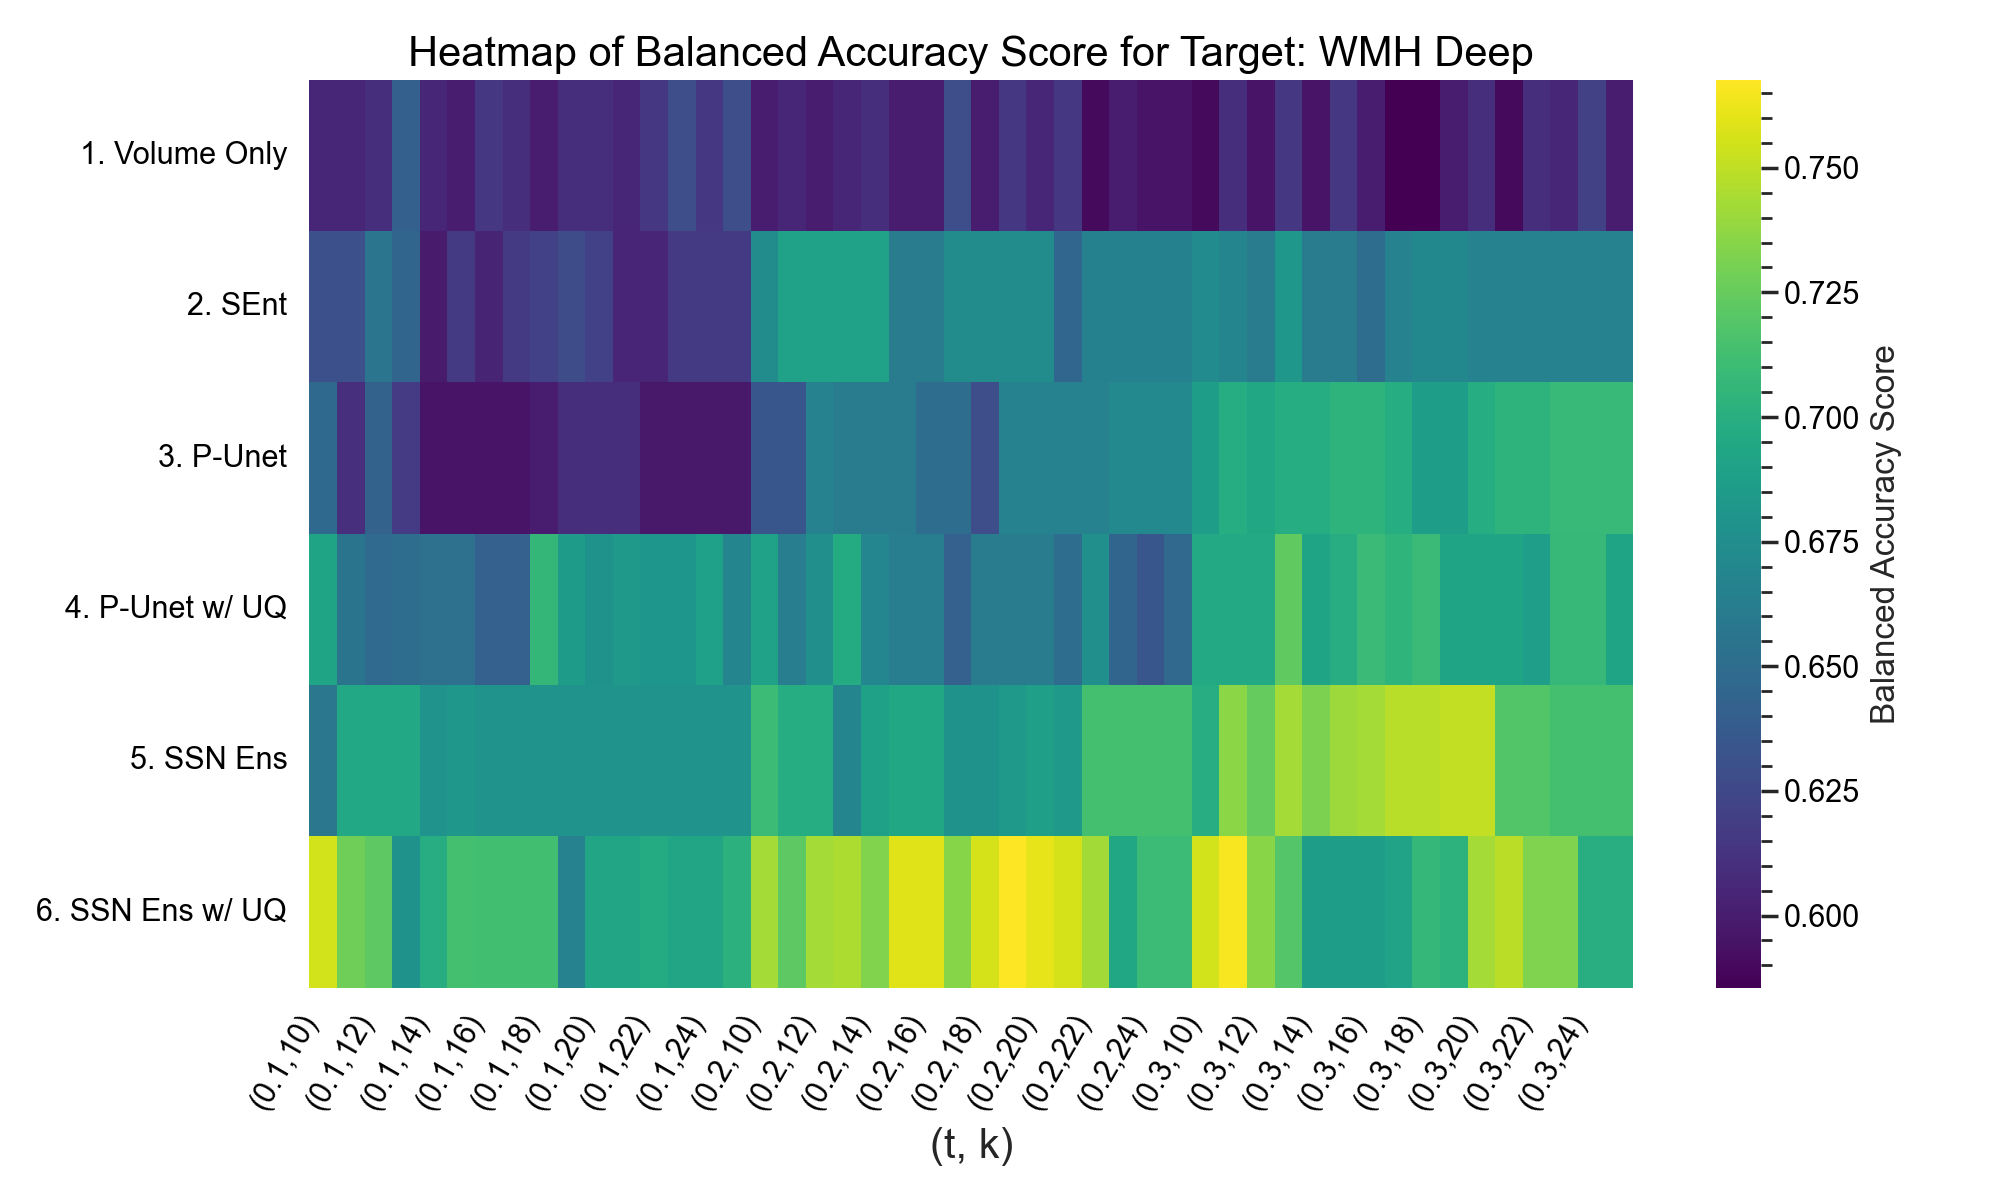

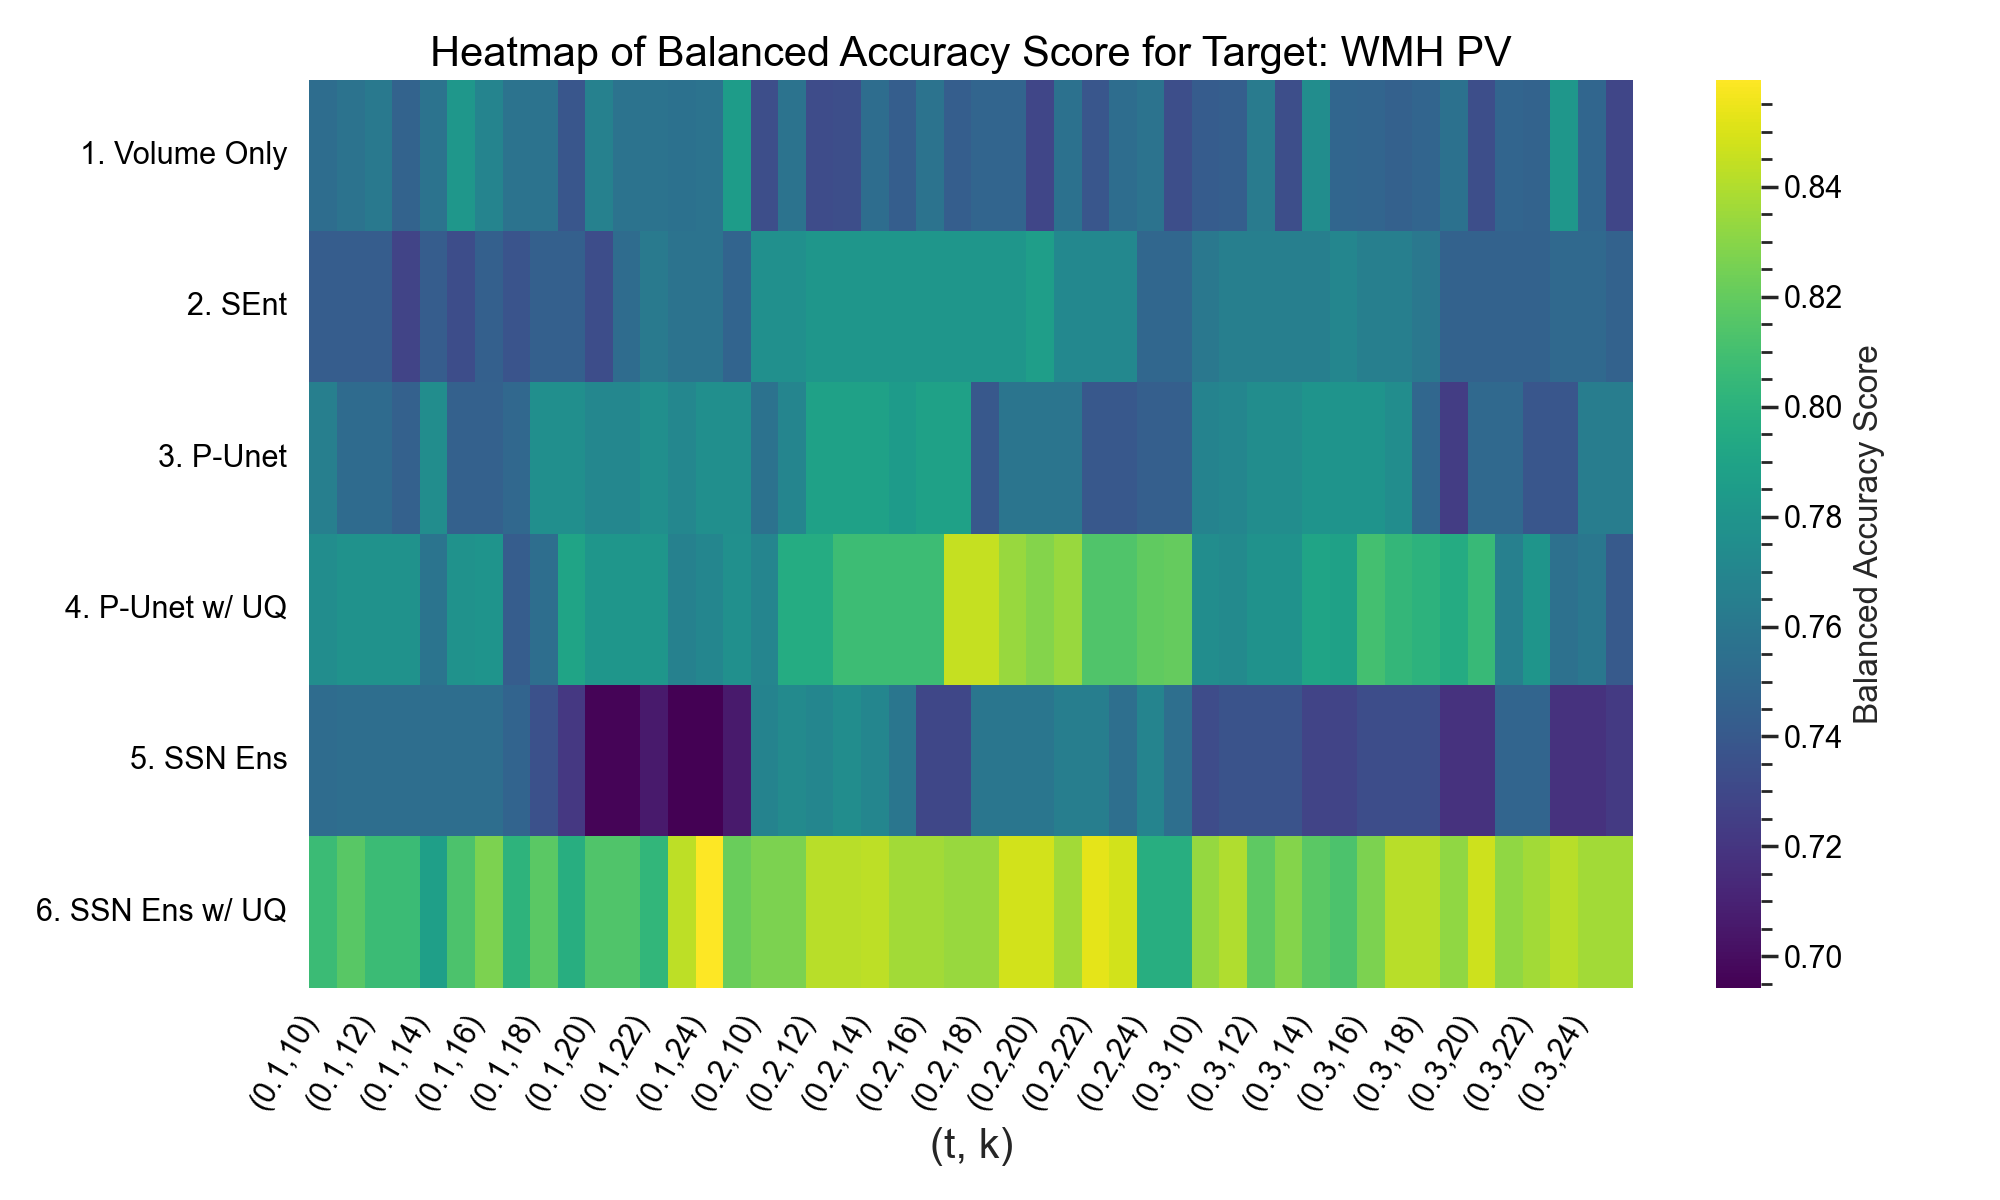

In [78]:
df = rdf[rdf['holdout_fold'] == 'mss3'].copy()
metric = 'test_bal_acc'
metric_name = "Balanced Accuracy Score"

# Sort the dataframe by k and t
df['k_t'] = df.apply(lambda row: f"({row['t']},{row['k']})", axis=1)
df = df.sort_values(by=['k', 't'])

# Create heatmaps for each target
targets = df['target'].unique()

fontsize=15
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'xtick.bottom': False, 'ytick.left': False})

for target in targets:
    target_df = df[df['target'] == target]
    heatmap_data = target_df.pivot(index='model_name', columns='k_t', values=metric)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=False, cmap='viridis', cbar_kws={'label': metric_name})
    plt.title(f"Heatmap of {metric_name} for Target: {target.replace('_', ' ')}", fontsize=fontsize)
    plt.xlabel("(t, k)", fontsize=fontsize)
    plt.ylabel("", fontsize=fontsize)
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.savefig(f"hparam_heatmap_{metric}_{target}.pdf")
    plt.show()

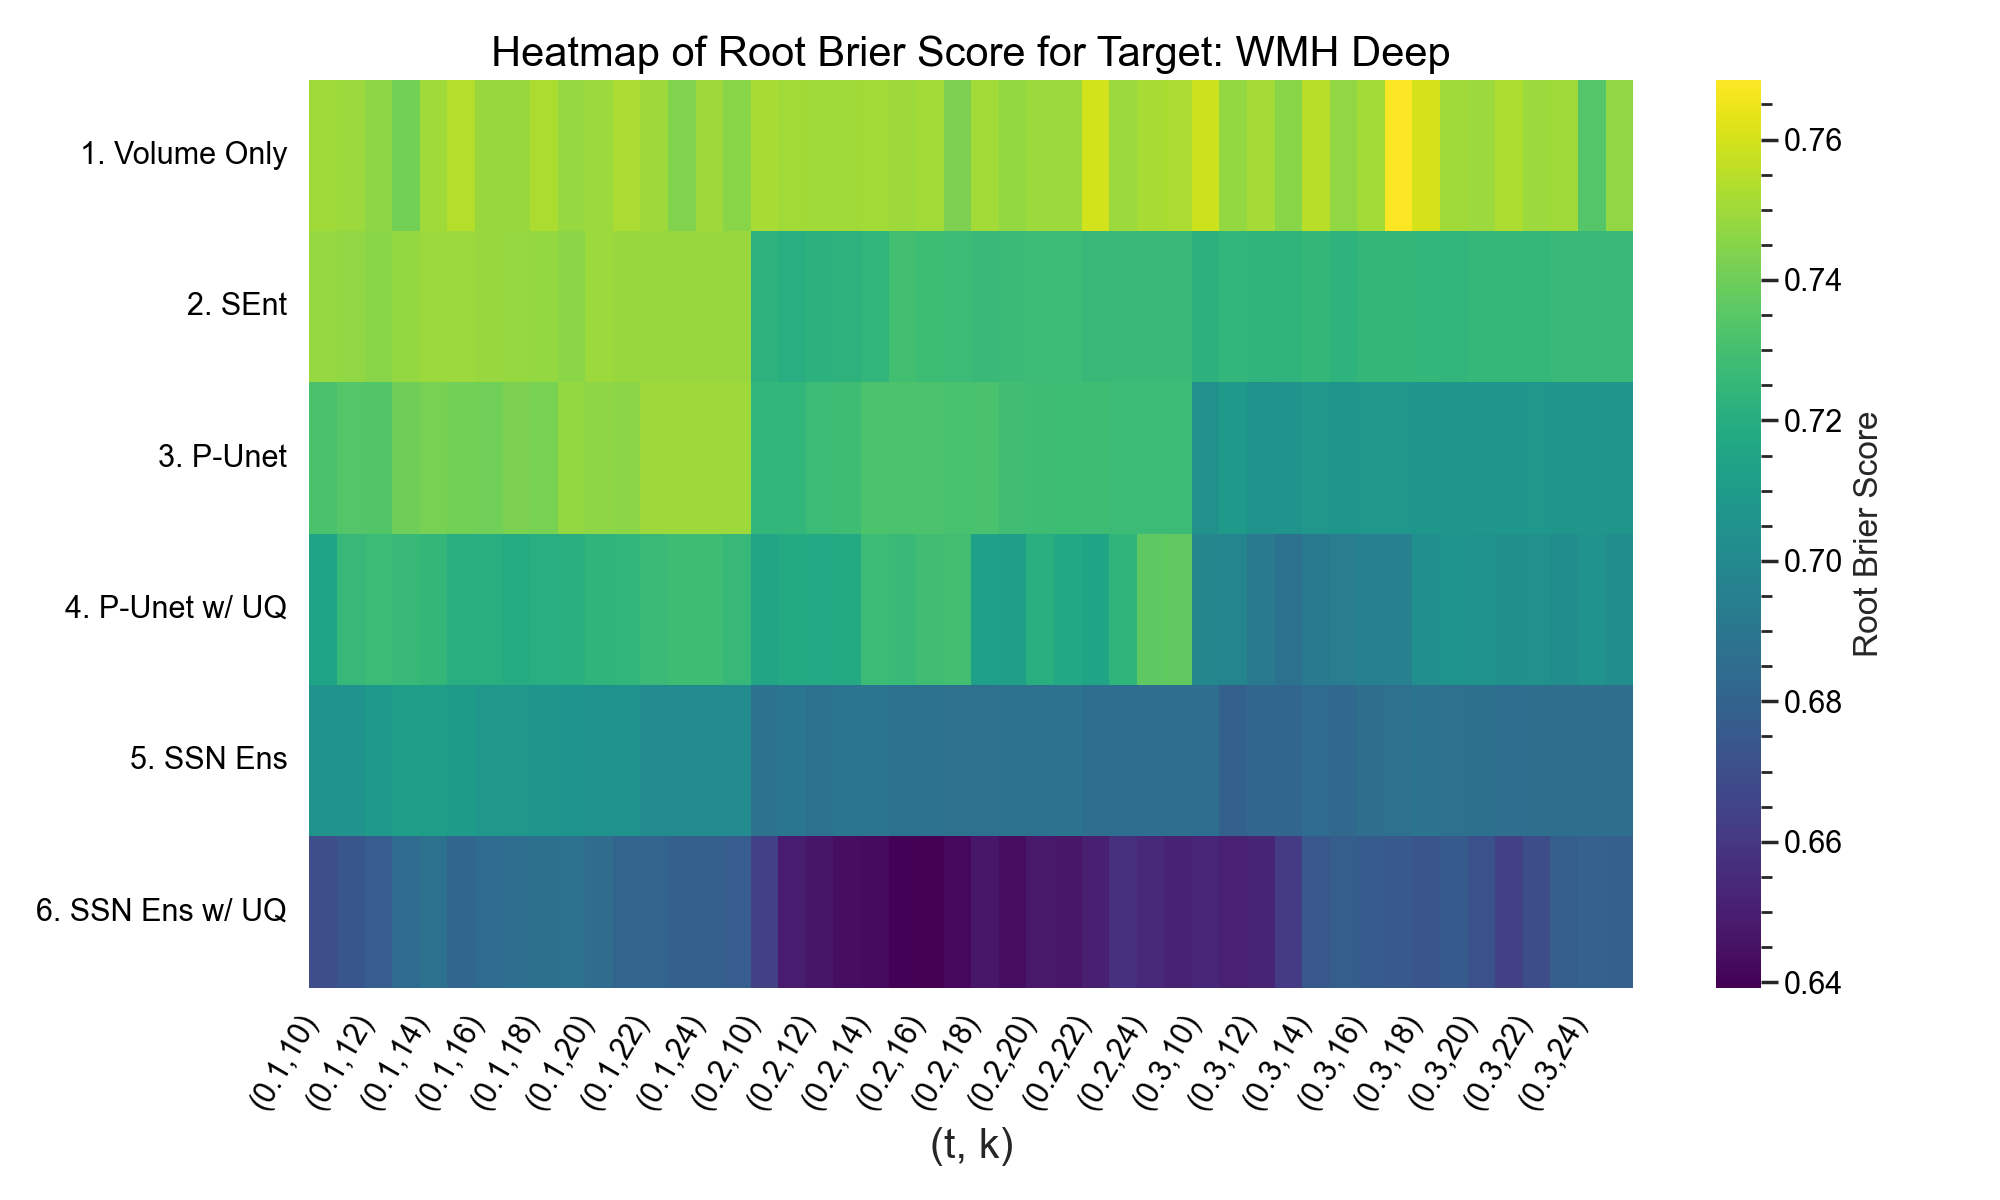

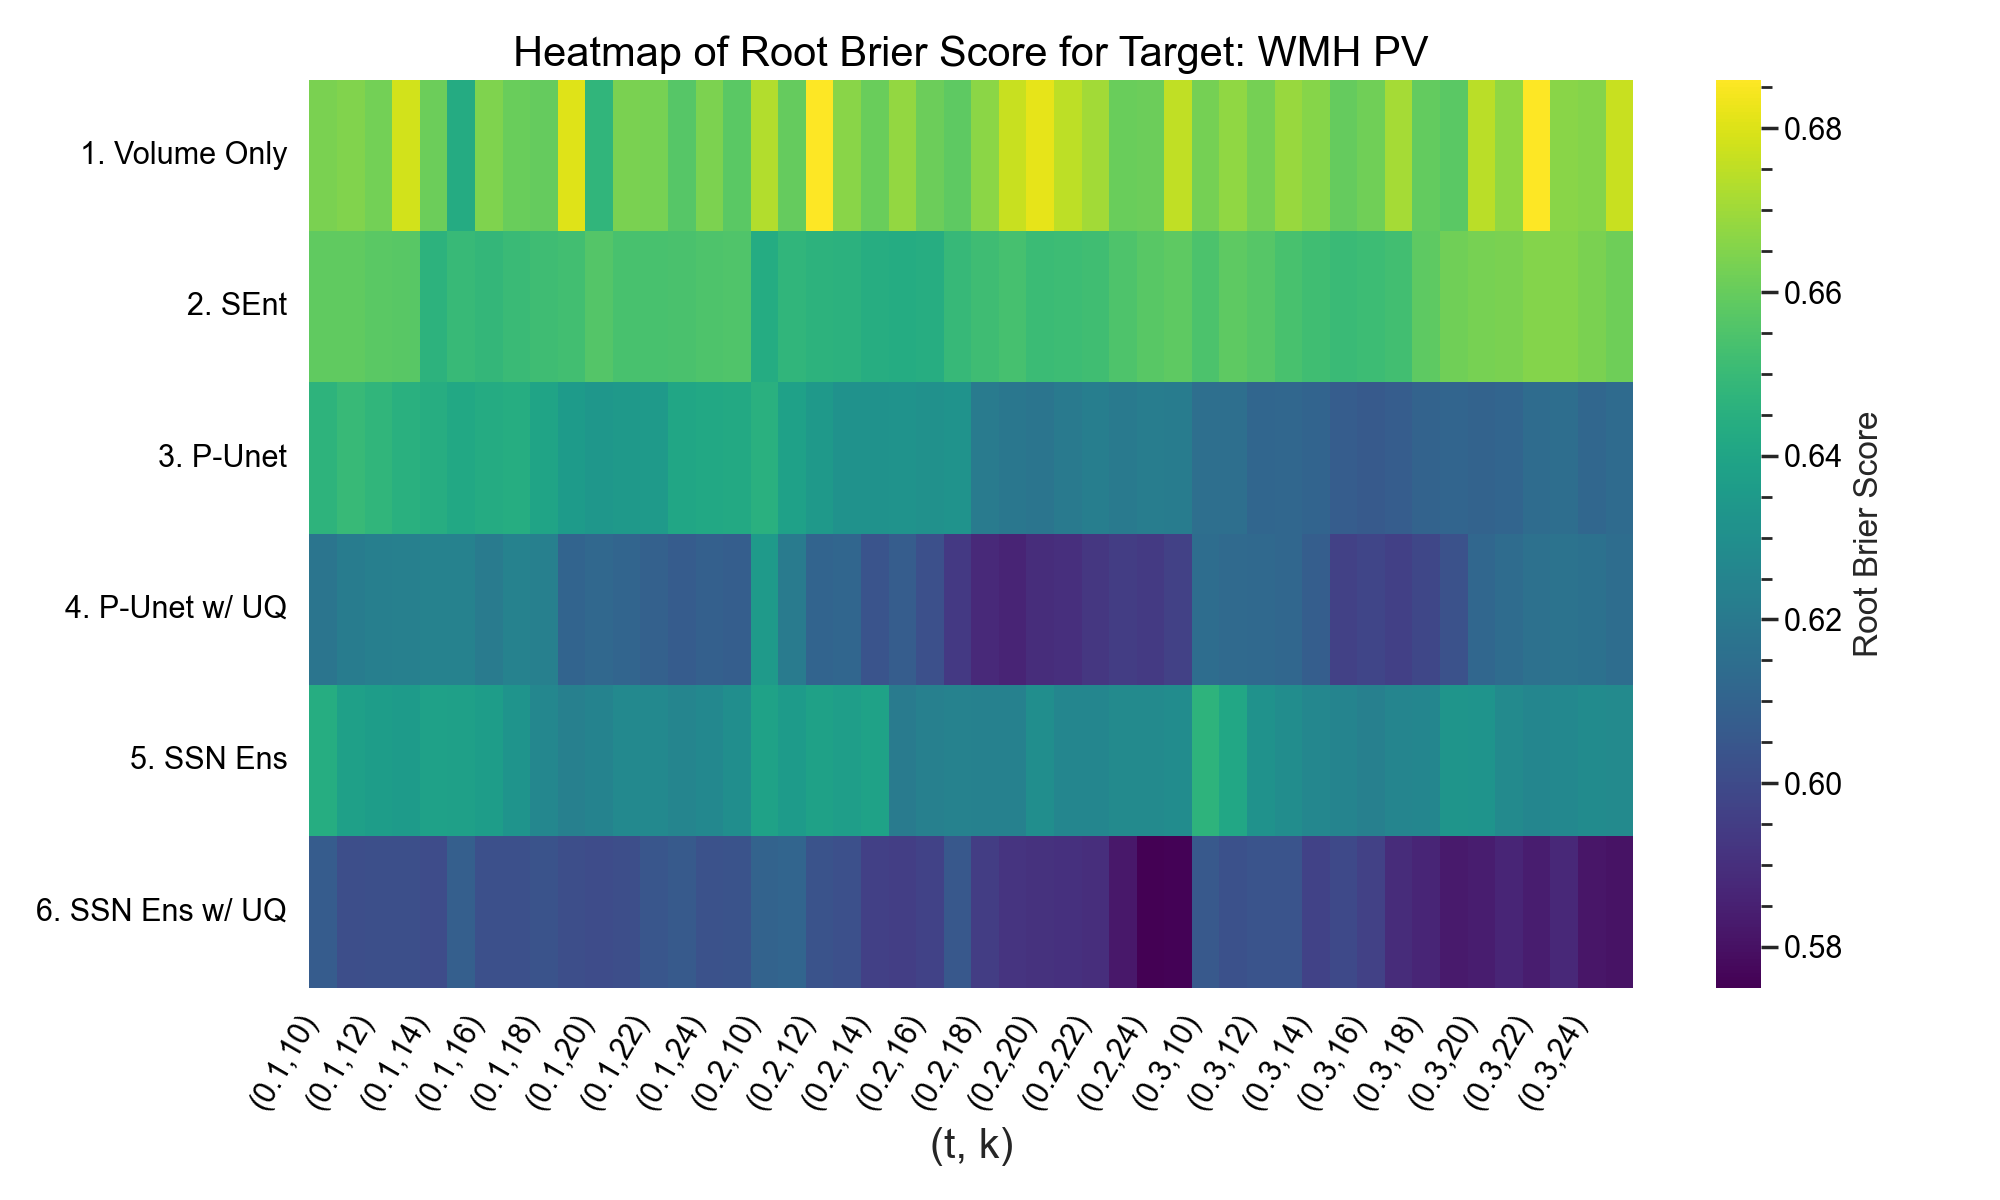

In [79]:
df = rdf[rdf['holdout_fold'] == 'mss3'].copy()
metric = 'test_rmbs'
metric_name = "Root Brier Score"

# Sort the dataframe by k and t
df['k_t'] = df.apply(lambda row: f"({row['t']},{row['k']})", axis=1)
df = df.sort_values(by=['k', 't'])

# Create heatmaps for each target
targets = df['target'].unique()

fontsize=15
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'xtick.bottom': False, 'ytick.left': False})

for target in targets:
    target_df = df[df['target'] == target]
    heatmap_data = target_df.pivot(index='model_name', columns='k_t', values=metric)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=False, cmap='viridis', cbar_kws={'label': metric_name})
    plt.title(f"Heatmap of {metric_name} for Target: {target.replace('_', ' ')}", fontsize=fontsize)
    plt.xlabel("(t, k)", fontsize=fontsize)
    plt.ylabel("", fontsize=fontsize)
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.savefig(f"hparam_heatmap_{metric}_{target}.pdf")
    plt.show()

In [50]:
from trustworthai.journal_run.new_MIA_fazekas_and_QC.general_utils import confusion_matrices, plot_confusion_matrix

In [47]:
target = "WMH_PV"
fold = 'test'
holdout_ds = 'mss3'


for model in ['vol', 'deterministic', 'ssn_ens_umap', 'punet_umap']:
    
    best_k = 0
    best_t = 0
    best_bal_acc = 0
    for k in range(10, 26):
        for t in [0.2, 0.3]:
            y = experiment_run_results[target][t][k][model][holdout_ds][fold]['y']
            y_pred = experiment_run_results[target][t][k][model][holdout_ds][fold]['pred']

            bal_acc = balanced_accuracy_score(y, y_pred)
            if bal_acc > best_bal_acc:
                best_k = k
                best_t = t
                best_bal_acc = bal_acc
                
    print(model, best_k, best_t, best_bal_acc)

vol 25 0.2 0.7769693541752365
deterministic 20 0.2 0.7860602632661456
ssn_ens_umap 22 0.2 0.8528640477169889
punet_umap 17 0.2 0.8449969148498562


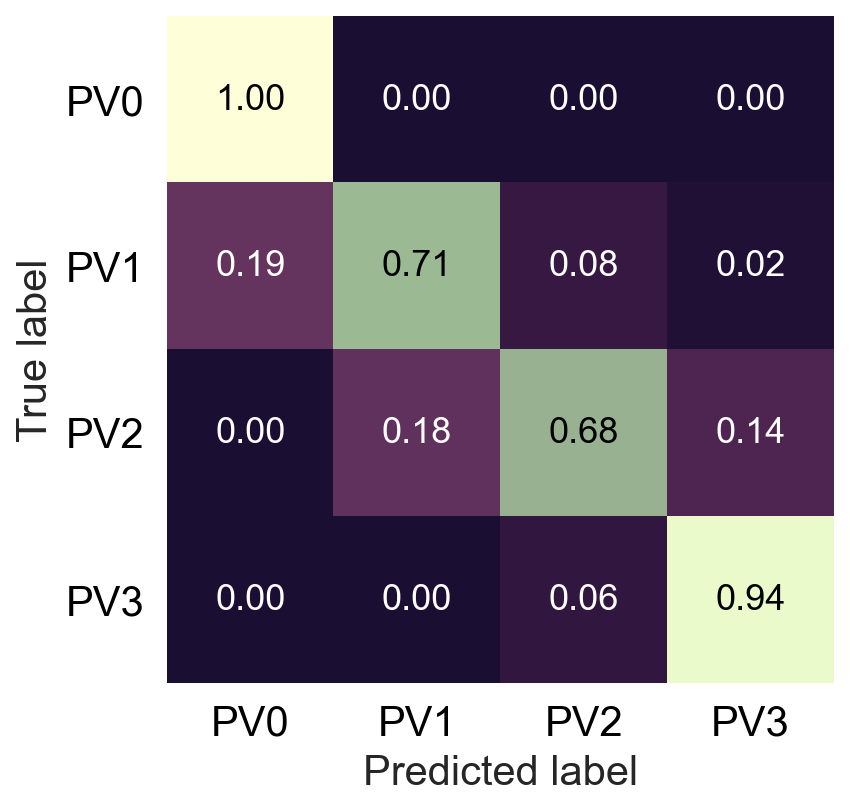

In [55]:
target = "WMH_PV"
holdout_ds = 'mss3'

t = 0.2
k = 18
confusion_matrices(
            [
                (experiment_run_results[target][t][k][model][holdout_ds]['test']['y'], experiment_run_results[target][t][k][model][holdout_ds]['test']['pred'])
                for model in ['ssn_ens_umap']
            ],
            cmap="tokyo", class_labels=['PV0', 'PV1', 'PV2', 'PV3'],
            ax_names = [None]
)

plt.savefig("confusion_pv_mss3_test_ssnens.jpg", bbox_inches='tight', dpi=300)

/home/s2208943/ipdis/WMH_UQ_assessment/trustworthai/journal_run/new_MIA_fazekas_and_QC/general_utils.py:207: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


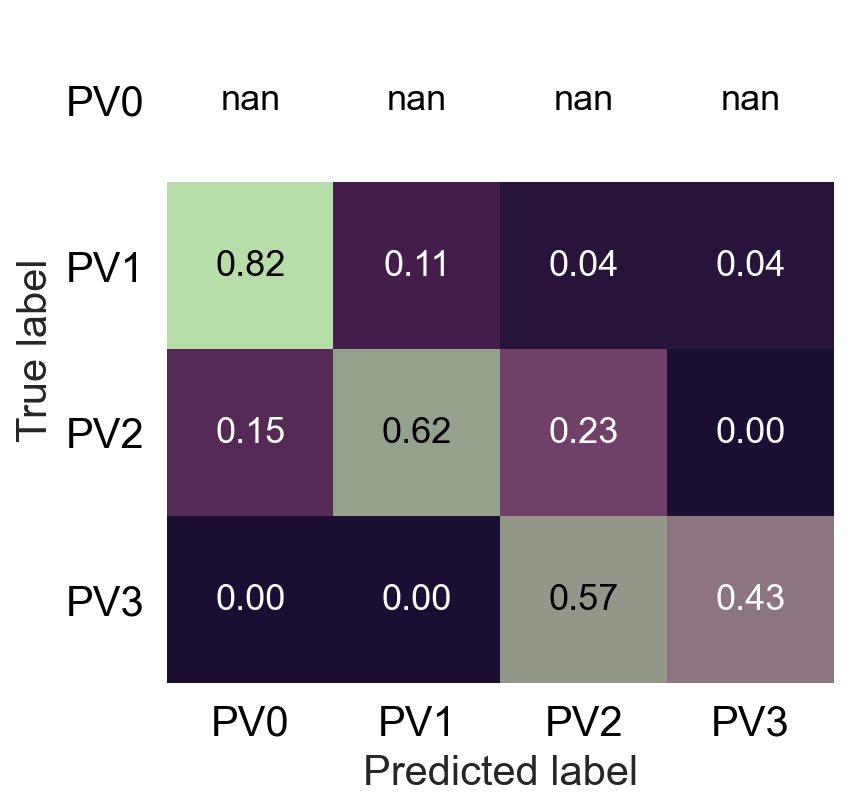

In [56]:
confusion_matrices(
            [
                (experiment_run_results[target][t][k][model][holdout_ds]['holdout']['y'], experiment_run_results[target][t][k][model][holdout_ds]['holdout']['pred'])
                for model in ['ssn_ens_umap']
            ],
            cmap="tokyo", class_labels=['PV0', 'PV1', 'PV2', 'PV3'],
            ax_names = [None]
)

plt.savefig("confusion_pv_mss3_holdout_ssnens.jpg", bbox_inches='tight', dpi=300)

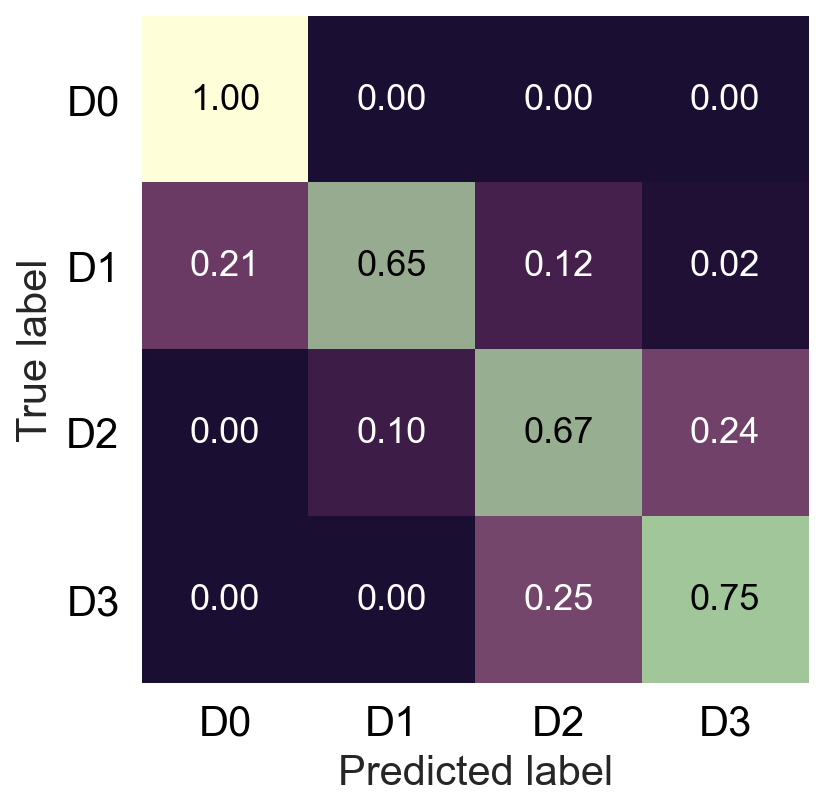

In [57]:
target = "WMH_Deep"
holdout_ds = 'mss3'

t = 0.2
k = 19
confusion_matrices(
            [
                (experiment_run_results[target][t][k][model][holdout_ds]['test']['y'], experiment_run_results[target][t][k][model][holdout_ds]['test']['pred'])
                for model in ['ssn_ens_umap']
            ],
            cmap="tokyo", class_labels=['D0', 'D1', 'D2', 'D3'],
            ax_names = [None]
)

plt.savefig("confusion_deep_mss3_test_ssnens.jpg", bbox_inches='tight', dpi=300)

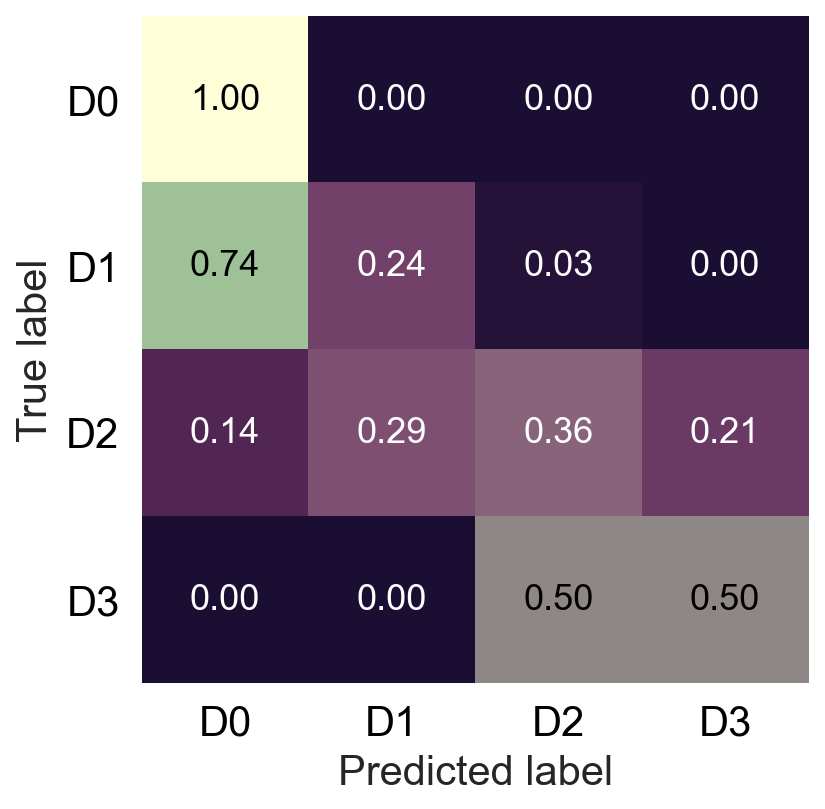

In [58]:
confusion_matrices(
            [
                (experiment_run_results[target][t][k][model][holdout_ds]['holdout']['y'], experiment_run_results[target][t][k][model][holdout_ds]['holdout']['pred'])
                for model in ['ssn_ens_umap']
            ],
            cmap="tokyo", class_labels=['D0', 'D1', 'D2', 'D3'],
            ax_names = [None]
)

plt.savefig("confusion_deep_mss3_holdout_ssnens.jpg", bbox_inches='tight', dpi=300)